# Load Packages

In [1]:
#### Import required Packages #####
import numpy as np
import pandas as pd
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import scipy

In [2]:
# Seaborn
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Load Data

In [3]:
# rawdata is direct import from excel

# Import of excel data --> NEEDS TO BE CHANGED TO CORRECT DATA
rawdata = pd.DataFrame(pd.read_excel("1_data/DataMomentumStrategy_TME.xlsx"))
rawdata.columns = ["Trading_day", "Date", "MSCI_EU", "Healthcare", "Financials", "Consumer_staples","Industrials","Consumer_discretionary","Materials", "Information_technology", "Energy", "Utilities", "Communication_services","Real_estate"]


# Do all the clean up before translating to df and only work with this from now on
df = rawdata
dff = rawdata #create this variable to test the data_cleaner function

df = df.sort_index(ascending=False) # Crucial to have ascending time series otherwise returns are wrong!!!
dff = dff.sort_index(ascending=False) # Crucial to have ascending time series otherwise returns are wrong!!!

df.isnull().values.any() # checking for NAs in our data frame -> needs to return False
#df.describe()
print(f"{df}\n\n\n{dff}")

Rf_annual = 0.01


     Trading_day       Date  MSCI_EU  Healthcare  Financials  \
6213          Di 1999-01-05   104.30      100.00      100.00   
6212          Mi 1999-01-06   106.68      102.85      103.52   
6211          Do 1999-01-07   105.39      105.35      105.23   
6210          Fr 1999-01-08   106.02      107.03      108.53   
6209          Mo 1999-01-11   104.50      106.55      106.62   
...          ...        ...      ...         ...         ...   
4             Mo 2022-10-24   135.08      234.17       57.10   
3             Di 2022-10-25   137.05      236.23       57.52   
2             Mi 2022-10-26   137.86      238.68       57.55   
1             Do 2022-10-27   137.79      236.37       57.91   
0             Fr 2022-10-28   137.99      240.09       57.71   

      Consumer_staples  Industrials  Consumer_discretionary  Materials  \
6213            100.00       100.00                  100.00     100.00   
6212            100.74       101.93                  102.37     101.50   
6211     

In [ ]:
# Set date as index -> only run once!
df.set_index("Date", inplace=True)

# Cut Momentum Frame

In [ ]:
# Exclude Trading Days column and MSCI_EU Benchmark to have only Momentum columns
prices = df.loc[:,"Healthcare":"Real_estate"]
prices.dtypes

In [ ]:
prices

In [ ]:
# Calculating Monthly returns
mtl_ret = prices.pct_change().resample("M").agg(lambda x: (1+x).prod()-1) # pct_change creates ordinary returns, resample Monthly and aggregating with the (1+x) -1 formula to get monthly ordinary returns
mtl_ret

In [ ]:
past_11 = (mtl_ret+1).rolling(11).apply(np.prod)-1 # accumulate returns over 11 months 
past_11.head(11)

In [ ]:
# Defining formation date <-  where portfolio gets created
formation = dt.datetime(1999, 12, 31, 0, 0)

# Defining MeasurementDate <- up to last date of month before formation date
end_measurement = formation - MonthEnd(1)
end_measurement

In [ ]:
# Past 12 Month performance without most recent month <- in this case Jan, Feb, Mar, Apr, Jun, Jul, Sep, Oct, Nov but not December!
ret_12 = past_11.loc[end_measurement]
ret_12 = ret_12.reset_index()
ret_12.rename(columns={ ret_12.columns[1]: "returns" }, inplace = True)
ret_12

In [ ]:
ret_12 = ret_12.sort_values(["returns"], ascending=False)
ret_12["bucket"] = [2,2,2,2,2,1,0,0,0,0,0] # Make three buckets
ret_12

In [ ]:
# Create winners and loser list based on bucket
winners = ret_12[ret_12.bucket == 2]
losers = ret_12[ret_12.bucket == 0]
winners

In [ ]:
# Calculate the winner and loser returns over the last 12 months excluding the most recent month
winnerret = mtl_ret.loc[formation + MonthEnd(1), mtl_ret.columns.isin(winners["index"])]
loserret = mtl_ret.loc[formation + MonthEnd(1), mtl_ret.columns.isin(losers["index"])]

In [ ]:
Momentumprofit = winnerret.mean() - loserret.mean()
Momentumprofit

# Functionalising this Methodology

In [4]:
def data_cleaner(pandas_df, index="Date", prices_start='Healthcare', prices_end='Real_estate', resample_freq='M', lookback=11):
    print(pandas_df.isnull().values.any())
    df = pandas_df.set_index(index, inplace=False)
    prices = df.loc[:,prices_start:prices_end]
    mtl_ret = prices.pct_change().resample(resample_freq).agg(lambda x: (1+x).prod()-1)
    past_11 = (1+mtl_ret).rolling(lookback).apply(np.prod)-1
    return prices, mtl_ret, past_11


In [ ]:
#test the data_cleaner function

prices, mtl_ret, past_11 = data_cleaner(dff, lookback = 11, resample_freq= 'M')
print(f'\nprices:\n {prices}, \nmonthly_return:\n {mtl_ret}, \npast_11:\n {past_11.head(12)}')

In [5]:
def momentum(formation, past_11, num_l_s=5):
    end_measurement = formation - MonthEnd(1)
    ret_12 = past_11.loc[end_measurement]
    ret_12 = ret_12.reset_index()
    ret_12.rename(columns={ ret_12.columns[1]: "returns" }, inplace = True)
    ret_12 = ret_12.sort_values(["returns"], ascending=False)
    
    middle = 11-2*num_l_s
    l_s = []
    for i in range(num_l_s):
        l_s.append(2)
    for i in range(middle):
        l_s.append(1)
    for i in range(num_l_s):
        l_s.append(0)
    ret_12["bucket"] = l_s # Make arbitrary number of buckets
    
    winners = ret_12[ret_12.bucket == 2]
    losers = ret_12[ret_12.bucket == 0]
    winnerret = mtl_ret.loc[formation + MonthEnd(1), mtl_ret.columns.isin(winners["index"])]
    loserret = mtl_ret.loc[formation + MonthEnd(1), mtl_ret.columns.isin(losers["index"])]
    Momentumprofit = winnerret.mean() - loserret.mean()
    return Momentumprofit







In [ ]:
formation = dt.datetime(1999, 12, 31, 0, 0)
#momentum(formation, past_11) # has to be identical with [35]
print(formation - MonthEnd(1))
print(formation + MonthEnd(1))

In [6]:
def benchmarker(pandas_df, profits_list, l_s_NR=5, lookback_period=11):
    dff = pandas_df.set_index("Date", inplace=False)
    
    dff = dff.sort_index(ascending=True)
    #print(dff.head(10))
    
    benchmark = dff[["MSCI_EU"]]
    benchmark = benchmark.loc["2000-01-31 00:00:00":"2022-09-30 00:00:00"]
    
    bm_mtl_ret = mtl_ret = benchmark.pct_change().resample("M").agg(lambda x: (1+x).prod()-1) # pct_change creates ordinary returns, resample Monthly and aggregating with the (1+x) -1 formula to get monthly ordinary returns
    comparison = pd.DataFrame(bm_mtl_ret)
    comparison["mom_ret"] = profits_list[:-1]
    comparison.rename(columns={ comparison.columns[0]: "bench_ret" }, inplace = True)
    comparison["bench_indexed"] = comparison["bench_ret"].add(1).cumprod()
    comparison["mom_indexed"] = comparison["mom_ret"].add(1).cumprod()
    #replace the first value with the manually calculated return for january 2000:
    comparison["bench_ret"] = comparison["bench_ret"].replace([0.000000], -0.0495175)
    comparison.loc["2000-01-31","bench_indexed"] = (1-0.0495175)
    print(comparison)
    
    fig, ax = plt.subplots()
    ax.plot(comparison.index,comparison.mom_indexed, label="Momentum", color="red")
    ax.plot(comparison.index,comparison.bench_indexed, label="MSCI EU", color="blue")
    ax.legend(loc="best")
    ax.set_ylabel('Monthly Returns (indexed)')
    ax.set_title(f"Momentum long/short {l_s_NR} sectors monthly rebalancing vs MSCI EU, indexed 31.12.1999\nLookback-Period: {lookback_period}")
    
    fig, ax = plt.subplots()
    ax.plot(comparison.index,comparison.mom_ret, label="Momentum", color="red")
    ax.plot(comparison.index,comparison.bench_ret, label="MSCI EU", color="blue")
    ax.legend(loc="best")
    ax.set_ylabel('Monthly Returns')
    ax.set_title(f"Momentum long/short {l_s_NR} sectors monthly rebalancing vs MSCI EU\nLookback-Period: {lookback_period}")
    
    return


In [ ]:
# Creating loop for every month  starting at formation date -> creates df with all these dates
for i in range(273): # Eig wären es 273 Monate zwischen 31.12.1999 und 31.12.2022 -> stimmt irgendwie ned ganz aber lauft jetzt halt so bis endi august
    print(formation + MonthEnd(i))

#wären es nicht 276 Monate? has mit emene Zeitspannen-rechner usgrechnet --> gahd ets bis endi november 2022
for i in range(276):
    print(formation + MonthEnd(i))


In [ ]:
# Creating loop for storing the profits and the realized dates of the momentum strategy
profits = []
dates = []

'''
for i in range(273):
    profits.append(momentum(formation + MonthEnd(i)))
    dates.append(formation + MonthEnd(i))
'''

#version 2.0 (da gahds nume bis 274 --> gid en error wenn en monet meh nimmsch)
for i in range(272):
    profits.append(momentum(formation + MonthEnd(i), past_11))
    dates.append(formation + MonthEnd(i))


In [ ]:
benchmarker(df, profits)

In [ ]:
mom = pd.DataFrame({"Dates": dates,"Profits": profits})
mom

### Check if the functions work properly

False
1999-12-31 00:00:00
2022-09-30 00:00:00
            bench_ret   mom_ret  bench_indexed  mom_indexed
Date                                                       
2000-01-31  -0.049517  0.051075       0.950483     1.051075
2000-02-29   0.067994  0.057946       1.067994     1.111980
2000-03-31   0.029254 -0.052601       1.099237     1.053489
2000-04-30   0.002649 -0.101531       1.102148     0.946528
2000-05-31  -0.026562 -0.064189       1.072873     0.885771
...               ...       ...            ...          ...
2022-05-31  -0.014752  0.033120       1.166837     1.777977
2022-06-30  -0.078505  0.027788       1.075234     1.827384
2022-07-31   0.075240 -0.080138       1.156134     1.680941
2022-08-31  -0.051596  0.043769       1.096482     1.754514
2022-09-30  -0.063805  0.022544       1.026521     1.794067

[273 rows x 4 columns]
            bench_ret   mom_ret  bench_indexed  mom_indexed
Date                                                       
2000-01-31  -0.049517  0.05107

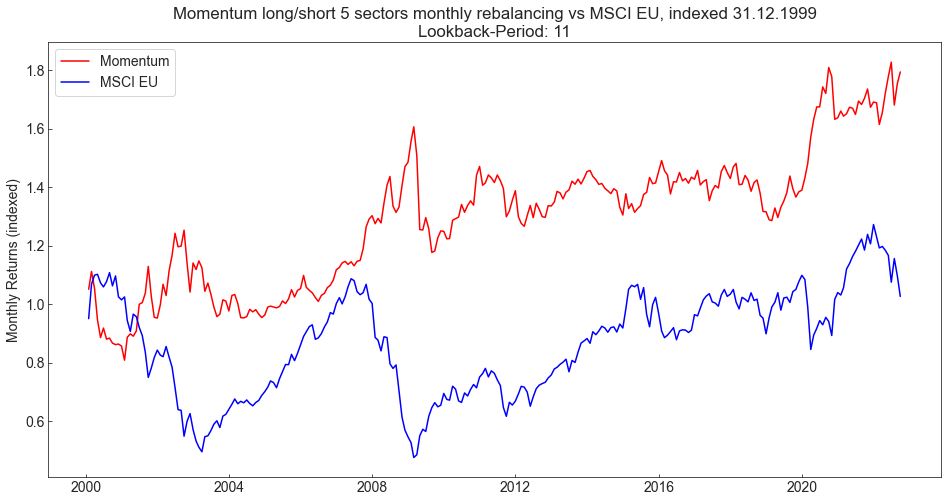

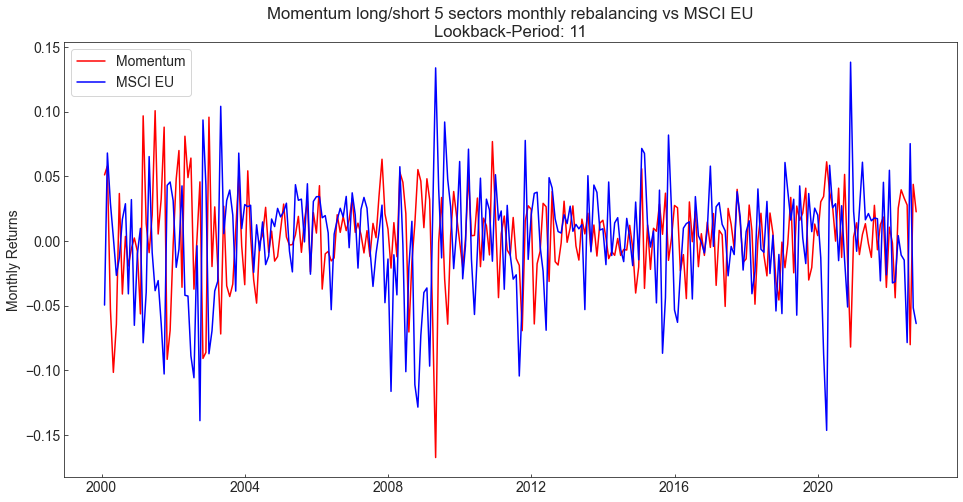

In [9]:
prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
#print(past_11.head(14))
#print(mtl_ret.head(14))

formation = dt.datetime(1999, 12, 31, 0, 0)

# Creating loop for storing the profits and the realized dates of the momentum strategy
profits = []
dates = []

for i in range(274):
    profits.append(momentum(formation + MonthEnd(i), past_11, num_l_s = 5))
    dates.append(formation + MonthEnd(i))
    if i == 0:
        print(formation + MonthEnd(i))
    elif i == 273:
        print(formation + MonthEnd(i))


benchmarker(df, profits)



## Create Summary Statistics

In [7]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

In [57]:
prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
#print(past_11.head(14))
#print(mtl_ret.head(14))

formation = dt.datetime(1999, 12, 31, 0, 0)

# Creating loop for storing the profits and the realized dates of the momentum strategy
profits = []
dates = []

for i in range(274):
    profits.append(momentum(formation + MonthEnd(i), past_11, num_l_s = 5))
    dates.append(formation + MonthEnd(i))

        
######################################################################################################
#above part to create the profits list, with the respective monthly profits of our momentum strategy

profits_2 = [x+1 for x in profits]


mom_mean = np.mean(profits)
mom_std = np.std(profits)
mom_geomean = g_mean(profits_2)-1
mom_skew = scipy.stats.skew(profits)
mom_kurtosis = scipy.stats.kurtosis(profits)
mom_min = np.min(profits)
mom_max = np.max(profits)
mom_mean_annual = (1+mom_mean)**(12)-1
benchmark_mean = np.mean(comp_list[0].bench_ret)
b = [x+1 for x in comp_list[0].bench_ret]
benchmark_geomean = g_mean(b)-1
bench_mean_annual = (1+benchmark_mean)**(12)-1
mom_std_annual = mom_std * np.sqrt(12)
benchmark_std = np.std(comp_list[0].bench_ret)
benchmark_std_annual = benchmark_std * np.sqrt(12)
benchmark_min = np.min(comp_list[0].bench_ret)
benchmark_max = np.max(comp_list[0].bench_ret)
SR_mom = (mom_mean_annual-Rf_annual)/mom_std_annual
SR_bench = (bench_mean_annual-Rf_annual)/benchmark_std_annual


print(f'''\nDescriptive statistics for our Long/Short PF:
Our PF has a sharp-ratio of: {round(SR_mom,4)}
The benchmark has a sharp-ratio of: {round(SR_bench,4)}

We get a arithmetic mean return (monthly) of: {round(mom_mean*100, 4)}%
We get a geometric mean (monthly) of: {round(mom_geomean*100,4)}%
We get an arithmetic mean (annualized) of: {round(mom_mean_annual, 4)*100}%
We get a benchmark arithmetic mean return (monthly) of: {round(benchmark_mean, 4)*100}%
We get a benchmark geometric mean return (monthly) of: {round(benchmark_geomean, 4)*100}%
We get a benchmark arithmetic mean return (annualized) of: {round(bench_mean_annual, 4)*100}%
We get a standard devation (monthly) of: {round(mom_std*100,4)}%
We get a standard deviation (annualized) of: {round(mom_std_annual, 4)*100}%
We get a benchmark std (monthly) of: {round(benchmark_std, 4)*100}%
We get a benchmark std (annualized) of: {round(benchmark_std_annual, 4)*100}%
We get a skewness of: {round(mom_skew,4)}
We get a kurtosis of: {round(mom_kurtosis,4)}
We get a minimum monthly return of: {round(mom_min,4)*100}%
We get a maximum monthly return of: {round(mom_max,4)*100}%
We get a minimum monthly benchmark return of: {round(benchmark_min,4)*100}%
We get a maximum monthly benchmark return of: {benchmark_max*100}%
''')

False

Descriptive statistics for our Long/Short PF:
Our PF has a sharp-ratio of: 0.1886
The benchmark has a sharp-ratio of: 0.0041

We get a arithmetic mean return (monthly) of: 0.2682%
We get a geometric mean (monthly) of: 0.2072%
We get an arithmetic mean (annualized) of: 3.27%
We get a benchmark arithmetic mean return (monthly) of: 0.09%
We get a benchmark geometric mean return (monthly) of: -0.01%
We get a benchmark arithmetic mean return (annualized) of: 1.06%
We get a standard devation (monthly) of: 3.4677%
We get a standard deviation (annualized) of: 12.01%
We get a benchmark std (monthly) of: 4.37%
We get a benchmark std (annualized) of: 15.14%
We get a skewness of: -0.5892
We get a kurtosis of: 2.3424
We get a minimum monthly return of: -16.74%
We get a maximum monthly return of: 10.07%
We get a minimum monthly benchmark return of: -14.64%
We get a maximum monthly benchmark return of: 13.819848404724144%



In [69]:
prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
#print(past_11.head(14))
#print(mtl_ret.head(14))

formation = dt.datetime(1999, 12, 31, 0, 0)

# Creating loop for storing the profits and the realized dates of the momentum strategy
profits = []
dates = []

for i in range(274):
    profits.append(momentum(formation + MonthEnd(i), past_11, num_l_s = 5)-0.001)
    dates.append(formation + MonthEnd(i))

        
######################################################################################################
#above part to create the profits list, with the respective monthly profits of our momentum strategy

profits_2 = [x+1 for x in profits]


mom_mean = np.mean(profits)
mom_std = np.std(profits)
mom_geomean = g_mean(profits_2)-1
mom_skew = scipy.stats.skew(profits)
mom_kurtosis = scipy.stats.kurtosis(profits)
mom_min = np.min(profits)
mom_max = np.max(profits)
mom_mean_annual = (1+mom_mean)**(12)-1
benchmark_mean = np.mean(comp_list[0].bench_ret)
b = [x+1 for x in comp_list[0].bench_ret]
benchmark_geomean = g_mean(b)-1
bench_mean_annual = (1+benchmark_mean)**(12)-1
mom_std_annual = mom_std * np.sqrt(12)
benchmark_std = np.std(comp_list[0].bench_ret)
benchmark_std_annual = benchmark_std * np.sqrt(12)
benchmark_min = np.min(comp_list[0].bench_ret)
benchmark_max = np.max(comp_list[0].bench_ret)
SR_mom = (mom_mean_annual-Rf_annual)/mom_std_annual
SR_bench = (bench_mean_annual-Rf_annual)/benchmark_std_annual


print(f'''\nDescriptive statistics for our Long/Short PF (including transaction cost):
Our PF has a sharp-ratio of: {round(SR_mom,4)}
The benchmark has a sharp-ratio of: {round(SR_bench,4)}

We get a arithmetic mean return (monthly) of: {round(mom_mean*100, 4)}%
We get a geometric mean (monthly) of: {round(mom_geomean*100,4)}%
We get an arithmetic mean (annualized) of: {round(mom_mean_annual, 4)*100}%
We get a benchmark arithmetic mean return (monthly) of: {round(benchmark_mean, 4)*100}%
We get a benchmark geometric mean return (monthly) of: {round(benchmark_geomean, 4)*100}%
We get a benchmark arithmetic mean return (annualized) of: {round(bench_mean_annual, 4)*100}%
We get a standard devation (monthly) of: {round(mom_std*100,4)}%
We get a standard deviation (annualized) of: {round(mom_std_annual, 4)*100}%
We get a benchmark std (monthly) of: {round(benchmark_std, 4)*100}%
We get a benchmark std (annualized) of: {round(benchmark_std_annual, 4)*100}%
We get a skewness of: {round(mom_skew,4)}
We get a kurtosis of: {round(mom_kurtosis,4)}
We get a minimum monthly return of: {round(mom_min,4)*100}%
We get a maximum monthly return of: {round(mom_max,4)*100}%
We get a minimum monthly benchmark return of: {round(benchmark_min,4)*100}%
We get a maximum monthly benchmark return of: {benchmark_max*100}%
''')

False

Descriptive statistics for our Long/Short PF (including transaction cost):
Our PF has a sharp-ratio of: 0.0863
The benchmark has a sharp-ratio of: 0.0041

We get a arithmetic mean return (monthly) of: 0.1682%
We get a geometric mean (monthly) of: 0.1072%
We get an arithmetic mean (annualized) of: 2.04%
We get a benchmark arithmetic mean return (monthly) of: 0.09%
We get a benchmark geometric mean return (monthly) of: -0.01%
We get a benchmark arithmetic mean return (annualized) of: 1.06%
We get a standard devation (monthly) of: 3.4677%
We get a standard deviation (annualized) of: 12.01%
We get a benchmark std (monthly) of: 4.37%
We get a benchmark std (annualized) of: 15.14%
We get a skewness of: -0.5892
We get a kurtosis of: 2.3424
We get a minimum monthly return of: -16.84%
We get a maximum monthly return of: 9.969999999999999%
We get a minimum monthly benchmark return of: -14.64%
We get a maximum monthly benchmark return of: 13.819848404724144%



In [25]:
comp_list[0].bench_ret

Date
2000-01-31   -0.049517
2000-02-29    0.067994
2000-03-31    0.029254
2000-04-30    0.002649
2000-05-31   -0.026562
                ...   
2022-05-31   -0.014752
2022-06-30   -0.078505
2022-07-31    0.075240
2022-08-31   -0.051596
2022-09-30   -0.063805
Freq: M, Name: bench_ret, Length: 273, dtype: float64

## Implement Transaction Costs

In [ ]:
prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
#print(past_11.head(14))
#print(mtl_ret.head(14))

formation = dt.datetime(1999, 12, 31, 0, 0)

# Creating loop for storing the profits and the realized dates of the momentum strategy
profits = []
dates = []

for i in range(274):
    profits.append(momentum(formation + MonthEnd(i), past_11, num_l_s = 5)-0.0001)
    dates.append(formation + MonthEnd(i))
    if i == 0:
        print(formation + MonthEnd(i))
    elif i == 273:
        print(formation + MonthEnd(i))


benchmarker(df, profits)


# Benchmarking

In [ ]:
benchmark = df[["MSCI_EU"]]
benchmark = benchmark.loc["1999-12-31 00:00:00":"2022-09-30 00:00:00"]
benchmark

In [ ]:
bm_mtl_ret = mtl_ret = benchmark.pct_change().resample("M").agg(lambda x: (1+x).prod()-1) # pct_change creates ordinary returns, resample Monthly and aggregating with the (1+x) -1 formula to get monthly ordinary returns
bm_mtl_ret


In [ ]:
#compare momentum result vs benchmark
comparison = pd.DataFrame(bm_mtl_ret)
comparison["mom_ret"] = profits
comparison.rename(columns={ comparison.columns[0]: "bench_ret" }, inplace = True)
comparison["bench_indexed"] = comparison["bench_ret"].add(1).cumprod()
comparison["mom_indexed"] = comparison["mom_ret"].add(1).cumprod()
comparison


In [ ]:
comparison

# Comparison Plot

In [ ]:
# Plotting
fig, ax = plt.subplots()
ax.plot(comparison.index,comparison.mom_indexed, label="Momentum", color="red")
ax.plot(comparison.index,comparison.bench_indexed, label="MSCI EU", color="blue")
ax.legend(loc="best")
ax.set_ylabel('Monthly Returns')
ax.set_title("Momentum long/short 5 sectors monthly rebalancing vs MSCI EU, indexed 31.12.1999")

## Create Various Plots for different lookback-periods and number of l/s Indices
## INCLUDING TRANSACTION COST

False
            bench_ret   mom_ret  bench_indexed  mom_indexed
Date                                                       
2000-01-31  -0.049517  0.050975       0.950483     1.050975
2000-02-29   0.067994  0.057846       1.067994     1.111770
2000-03-31   0.029254 -0.052701       1.099237     1.053179
2000-04-30   0.002649 -0.101631       1.102148     0.946143
2000-05-31  -0.026562 -0.064289       1.072873     0.885316
...               ...       ...            ...          ...
2022-05-31  -0.014752  0.033020       1.166837     1.730855
2022-06-30  -0.078505  0.027688       1.075234     1.778780
2022-07-31   0.075240 -0.080238       1.156134     1.636054
2022-08-31  -0.051596  0.043669       1.096482     1.707499
2022-09-30  -0.063805  0.022444       1.026521     1.745822

[273 rows x 4 columns]


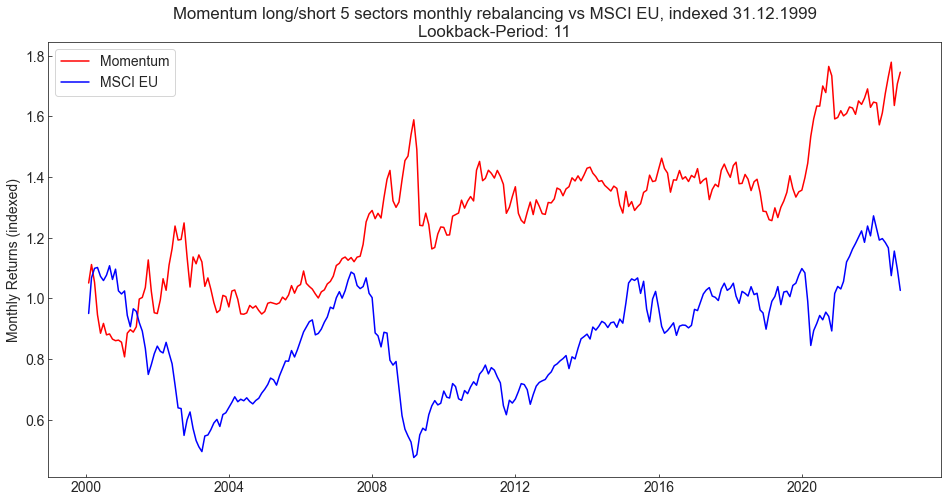

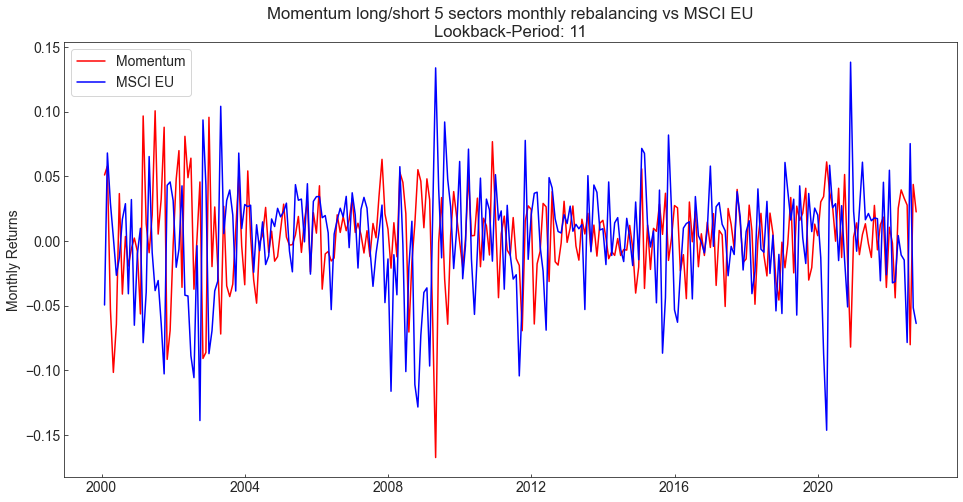

In [22]:
# l/s = 5 , lookback = 11

#first again, we need to create the data (just copy paste from above cell)

#create the data
prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
formation = dt.datetime(1999, 12, 31, 0, 0)

# Creating loop for storing the profits and the realized dates of the momentum strategy
profits = []
dates = []
for i in range(274):
    profits.append(momentum(formation + MonthEnd(i), past_11, num_l_s = 5)-0.0001)
    dates.append(formation + MonthEnd(i))

#compare with benchmark
benchmarker(df, profits, l_s_NR = 5, lookback_period = 11)


In [ ]:
for j in [1,2,3,5]:
    # l/s = 3 , lookback = 11

    #first again, we need to create the data (just copy paste from above cell)

    #create the data
    prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
    formation = dt.datetime(1999, 12, 31, 0, 0)

    # Creating loop for storing the profits and the realized dates of the momentum strategy
    profits = []
    dates = []
    for i in range(274):
        profits.append(momentum(formation + MonthEnd(i), past_11, num_l_s = j)-0.0001)
        dates.append(formation + MonthEnd(i))

    #compare with benchmark
    benchmarker(df, profits, l_s_NR = j, lookback_period = 11)



In [7]:
#change the benchmarker function to not create the plots but give the data to create the plots externally

def benchmarker_adapted(pandas_df, profits_list):
    dff = pandas_df.set_index("Date", inplace=False)
    
    dff = dff.sort_index(ascending=True)
    #print(dff.head(10))
    
    benchmark = dff[["MSCI_EU"]]
    benchmark = benchmark.loc["2000-01-31 00:00:00":"2022-09-30 00:00:00"]
    
    bm_mtl_ret = mtl_ret = benchmark.pct_change().resample("M").agg(lambda x: (1+x).prod()-1) # pct_change creates ordinary returns, resample Monthly and aggregating with the (1+x) -1 formula to get monthly ordinary returns
    comparison = pd.DataFrame(bm_mtl_ret)
    comparison["mom_ret"] = profits_list[:-1]
    comparison.rename(columns={ comparison.columns[0]: "bench_ret" }, inplace = True)
    comparison["bench_indexed"] = comparison["bench_ret"].add(1).cumprod()
    comparison["mom_indexed"] = comparison["mom_ret"].add(1).cumprod()
    #replace the first value with the manually calculated return for january 2000:
    comparison["bench_ret"] = comparison["bench_ret"].replace([0.000000], -0.0495175)
    comparison.loc["2000-01-31","bench_indexed"] = (1-0.0495175)
    print(comparison)
    
    
    return comparison


In [23]:
comp_list = []

for j in [1,2,3,5]:
    # l/s = 3 , lookback = 11

    #first again, we need to create the data (just copy paste from above cell)

    #create the data
    prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
    formation = dt.datetime(1999, 12, 31, 0, 0)

    # Creating loop for storing the profits and the realized dates of the momentum strategy
    profits = []
    dates = []
    for i in range(274):
        profits.append(momentum(formation + MonthEnd(i), past_11, num_l_s = j))
        dates.append(formation + MonthEnd(i))

    #compare with benchmark
    comp_list.append(benchmarker_adapted(df, profits))
    
comp_list_2 = []
for j in [1,2,3,5]:
    # l/s = 3 , lookback = 11

    #first again, we need to create the data (just copy paste from above cell)

    #create the data
    prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
    formation = dt.datetime(1999, 12, 31, 0, 0)

    # Creating loop for storing the profits and the realized dates of the momentum strategy
    profits = []
    dates = []
    for i in range(274):
        profits.append(momentum(formation + MonthEnd(i), past_11, num_l_s = j)-0.001)
        dates.append(formation + MonthEnd(i))

    #compare with benchmark
    comp_list_2.append(benchmarker_adapted(df, profits))




False
            bench_ret   mom_ret  bench_indexed  mom_indexed
Date                                                       
2000-01-31  -0.049517  0.143414       1.000000     1.143414
2000-02-29   0.067994  0.092050       1.067994     1.248665
2000-03-31   0.029254 -0.012692       1.099237     1.232817
2000-04-30   0.002649 -0.154419       1.102148     1.042446
2000-05-31  -0.026562 -0.099566       1.072873     0.938654
...               ...       ...            ...          ...
2022-05-31  -0.014752  0.116953       1.166837     0.537183
2022-06-30  -0.078505 -0.044872       1.075234     0.513079
2022-07-31   0.075240 -0.081325       1.156134     0.471352
2022-08-31  -0.051596  0.154258       1.096482     0.544062
2022-09-30  -0.063805  0.120519       1.026521     0.609632

[273 rows x 4 columns]
False
            bench_ret   mom_ret  bench_indexed  mom_indexed
Date                                                       
2000-01-31  -0.049517  0.125456       1.000000     1.125456
2000

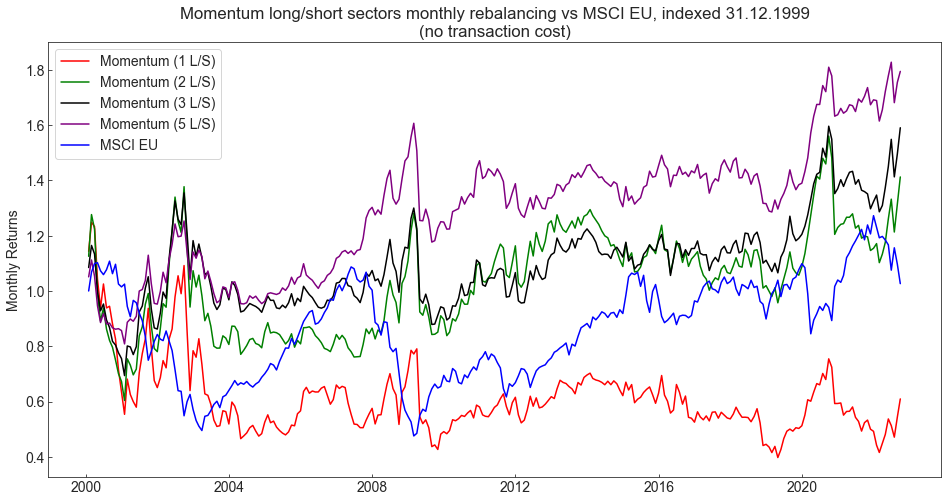

In [29]:
# Plotting all the different l/s in one graph with the benchmark together
# NO TRANSACTION COST


fig, ax = plt.subplots()
ax.plot(comp_list[1].index, comp_list[0].mom_indexed, label="Momentum (1 L/S)", color = "red")
ax.plot(comp_list[1].index, comp_list[1].mom_indexed, label="Momentum (2 L/S)", color = "green")
ax.plot(comp_list[1].index, comp_list[2].mom_indexed, label="Momentum (3 L/S)", color = "black")
ax.plot(comp_list[1].index, comp_list[3].mom_indexed, label="Momentum (5 L/S)", color = "purple")
ax.plot(comp_list[1].index,comp_list[1].bench_indexed, label="MSCI EU", color="blue")
ax.legend(loc="best")
ax.set_ylabel('Monthly Returns (cumulative)')
ax.set_title("Momentum long/short sectors monthly rebalancing vs MSCI EU, indexed 31.12.1999\n(no transaction cost)")

plt.savefig('Momentum_Overview_no_TC.png')


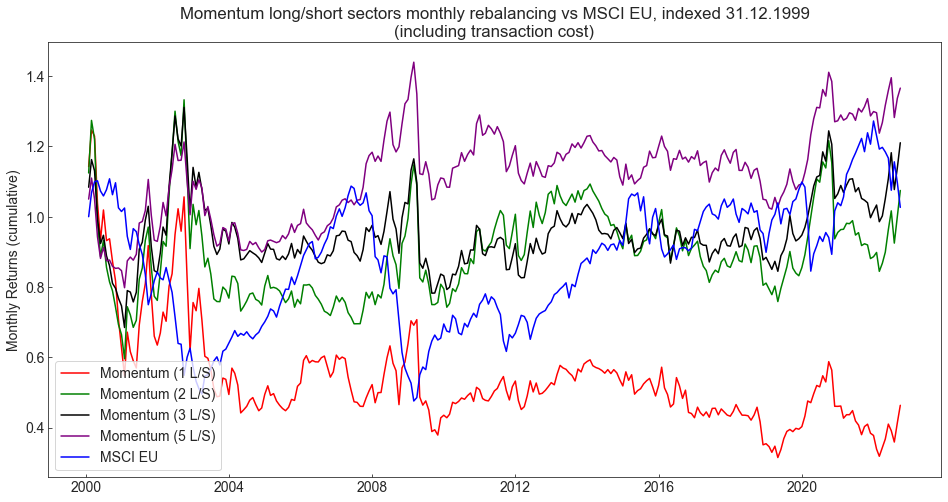

In [31]:
# Plotting all the different l/s in one graph with the benchmark together
# INCL TRANSACTION COST


fig, ax = plt.subplots()
ax.plot(comp_list_2[1].index, comp_list_2[0].mom_indexed, label="Momentum (1 L/S)", color = "red")
ax.plot(comp_list_2[1].index, comp_list_2[1].mom_indexed, label="Momentum (2 L/S)", color = "green")
ax.plot(comp_list_2[1].index, comp_list_2[2].mom_indexed, label="Momentum (3 L/S)", color = "black")
ax.plot(comp_list_2[1].index, comp_list_2[3].mom_indexed, label="Momentum (5 L/S)", color = "purple")
ax.plot(comp_list_2[1].index,comp_list_2[1].bench_indexed, label="MSCI EU", color="blue")
ax.legend(loc="best")
ax.set_ylabel('Monthly Returns (cumulative)')
ax.set_title("Momentum long/short sectors monthly rebalancing vs MSCI EU, indexed 31.12.1999\n(including transaction cost)")

plt.savefig('Momentum_Overview_incl_TC.png')


# Long-Only

In [58]:
def momentum_lo(formation, past_11, num_l_s=5):
    end_measurement = formation - MonthEnd(1)
    ret_12 = past_11.loc[end_measurement]
    ret_12 = ret_12.reset_index()
    ret_12.rename(columns={ ret_12.columns[1]: "returns" }, inplace = True)
    ret_12 = ret_12.sort_values(["returns"], ascending=False)
    
    middle = 11-num_l_s
    l_s = []
    for i in range(num_l_s):
        l_s.append(2)
    for i in range(middle):
        l_s.append(1)
    ret_12["bucket"] = l_s # Make arbitrary number of buckets
    
    winners = ret_12[ret_12.bucket == 2]
    winnerret = mtl_ret.loc[formation + MonthEnd(1), mtl_ret.columns.isin(winners["index"])]
    Momentumprofit = winnerret.mean()
    return Momentumprofit





In [64]:
comp_list_lo = []

for j in [1,2,3,5]:
    # l/s = 3 , lookback = 11

    #first again, we need to create the data (just copy paste from above cell)

    #create the data
    prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
    formation = dt.datetime(1999, 12, 31, 0, 0)

    # Creating loop for storing the profits and the realized dates of the momentum strategy
    profits_lo = []
    dates_lo = []
    for i in range(274):
        profits_lo.append(momentum_lo(formation + MonthEnd(i), past_11, num_l_s = j))
        dates_lo.append(formation + MonthEnd(i))

    #compare with benchmark
    comp_list_lo.append(benchmarker_adapted(df, profits_lo))
    
comp_list_lo_2 = []
for j in [1,2,3,5]:
    # l/s = 3 , lookback = 11

    #first again, we need to create the data (just copy paste from above cell)

    #create the data
    prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
    formation = dt.datetime(1999, 12, 31, 0, 0)

    # Creating loop for storing the profits and the realized dates of the momentum strategy
    profits_lo = []
    dates_lo = []
    for i in range(274):
        profits_lo.append(momentum_lo(formation + MonthEnd(i), past_11, num_l_s = j)-0.001)
        dates_lo.append(formation + MonthEnd(i))

    #compare with benchmark
    comp_list_lo_2.append(benchmarker_adapted(df, profits_lo))




False
            bench_ret   mom_ret  bench_indexed  mom_indexed
Date                                                       
2000-01-31  -0.049517  0.070427       0.950483     1.070427
2000-02-29   0.067994  0.198849       1.067994     1.283280
2000-03-31   0.029254  0.044536       1.099237     1.340433
2000-04-30   0.002649 -0.103693       1.102148     1.201439
2000-05-31  -0.026562 -0.066949       1.072873     1.121004
...               ...       ...            ...          ...
2022-05-31  -0.014752  0.102716       1.166837     0.851921
2022-06-30  -0.078505 -0.110470       1.075234     0.757810
2022-07-31   0.075240  0.034833       1.156134     0.784207
2022-08-31  -0.051596  0.027598       1.096482     0.805849
2022-09-30  -0.063805 -0.052967       1.026521     0.763166

[273 rows x 4 columns]
False
            bench_ret   mom_ret  bench_indexed  mom_indexed
Date                                                       
2000-01-31  -0.049517  0.069620       0.950483     1.069620
2000

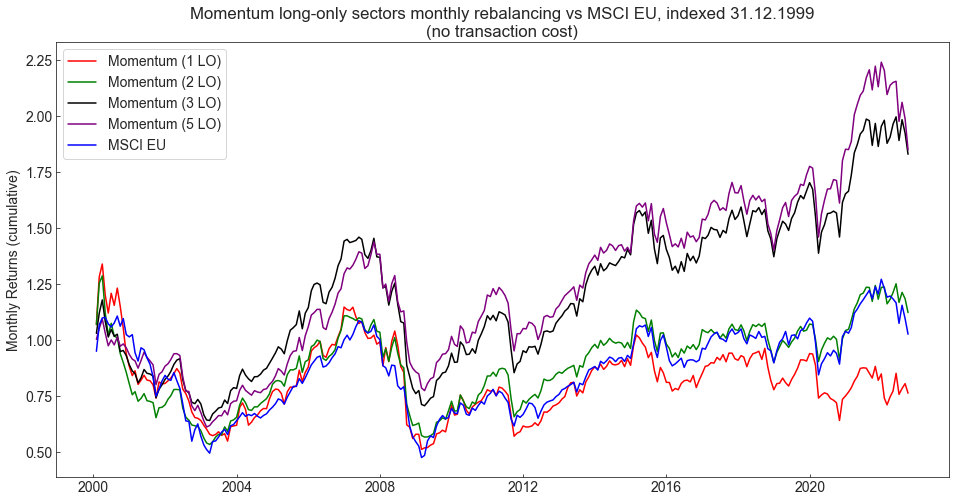

In [65]:
# Plotting all the different l/s in one graph with the benchmark together
# NO TRANSACTION COST


fig, ax = plt.subplots()
ax.plot(comp_list_lo[1].index, comp_list_lo[0].mom_indexed, label="Momentum (1 LO)", color = "red")
ax.plot(comp_list_lo[1].index, comp_list_lo[1].mom_indexed, label="Momentum (2 LO)", color = "green")
ax.plot(comp_list_lo[1].index, comp_list_lo[2].mom_indexed, label="Momentum (3 LO)", color = "black")
ax.plot(comp_list_lo[1].index, comp_list_lo[3].mom_indexed, label="Momentum (5 LO)", color = "purple")
ax.plot(comp_list_lo[1].index,comp_list_lo[1].bench_indexed, label="MSCI EU", color="blue")
ax.legend(loc="best")
ax.set_ylabel('Monthly Returns (cumulative)')
ax.set_title("Momentum long-only sectors monthly rebalancing vs MSCI EU, indexed 31.12.1999\n(no transaction cost)")

plt.savefig('Momentum_Overview_no_TC_LO.png')


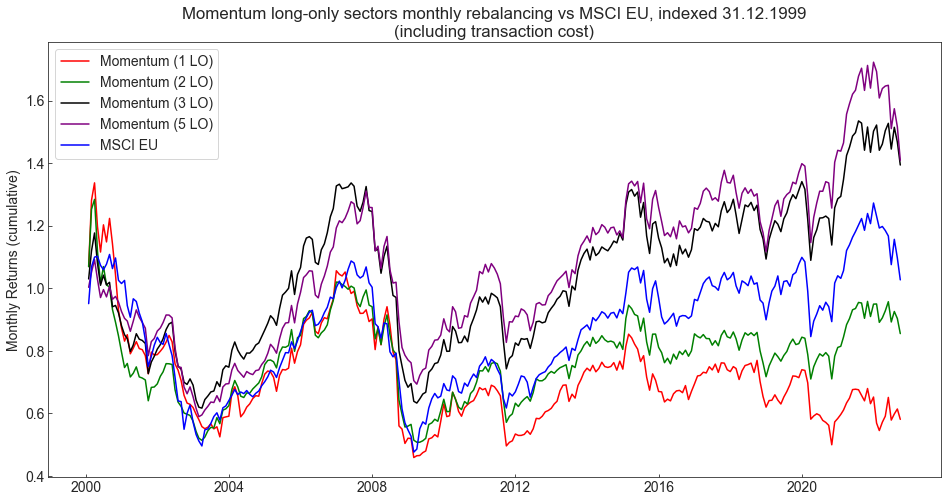

In [66]:
# Plotting all the different l/s in one graph with the benchmark together
# INCL TRANSACTION COST


fig, ax = plt.subplots()
ax.plot(comp_list_lo_2[1].index, comp_list_lo_2[0].mom_indexed, label="Momentum (1 LO)", color = "red")
ax.plot(comp_list_lo_2[1].index, comp_list_lo_2[1].mom_indexed, label="Momentum (2 LO)", color = "green")
ax.plot(comp_list_lo_2[1].index, comp_list_lo_2[2].mom_indexed, label="Momentum (3 LO)", color = "black")
ax.plot(comp_list_lo_2[1].index, comp_list_lo_2[3].mom_indexed, label="Momentum (5 LO)", color = "purple")
ax.plot(comp_list_lo_2[1].index,comp_list_lo_2[1].bench_indexed, label="MSCI EU", color="blue")
ax.legend(loc="best")
ax.set_ylabel('Monthly Returns (cumulative)')
ax.set_title("Momentum long-only sectors monthly rebalancing vs MSCI EU, indexed 31.12.1999\n(including transaction cost)")

plt.savefig('Momentum_Overview_incl_TC_LO.png')


In [71]:
prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
#print(past_11.head(14))
#print(mtl_ret.head(14))

formation = dt.datetime(1999, 12, 31, 0, 0)

# Creating loop for storing the profits and the realized dates of the momentum strategy
profits_lo = []
dates_lo = []

for i in range(274):
    profits_lo.append(momentum_lo(formation + MonthEnd(i), past_11, num_l_s = 5))
    dates_lo.append(formation + MonthEnd(i))

        
######################################################################################################
#above part to create the profits list, with the respective monthly profits of our momentum strategy

profits_2_lo = [x+1 for x in profits_lo]


mom_mean = np.mean(profits_lo)
mom_std = np.std(profits_lo)
mom_geomean = g_mean(profits_2_lo)-1
mom_skew = scipy.stats.skew(profits_lo)
mom_kurtosis = scipy.stats.kurtosis(profits_lo)
mom_min = np.min(profits_lo)
mom_max = np.max(profits_lo)
mom_mean_annual = (1+mom_mean)**(12)-1
benchmark_mean = np.mean(comp_list[0].bench_ret)
b = [x+1 for x in comp_list[0].bench_ret]
benchmark_geomean = g_mean(b)-1
bench_mean_annual = (1+benchmark_mean)**(12)-1
mom_std_annual = mom_std * np.sqrt(12)
benchmark_std = np.std(comp_list[0].bench_ret)
benchmark_std_annual = benchmark_std * np.sqrt(12)
benchmark_min = np.min(comp_list[0].bench_ret)
benchmark_max = np.max(comp_list[0].bench_ret)
SR_mom = (mom_mean_annual-Rf_annual)/mom_std_annual
SR_bench = (bench_mean_annual-Rf_annual)/benchmark_std_annual


print(f'''\nDescriptive statistics for our Long PF:
Our PF has a sharp-ratio of: {round(SR_mom,4)}
The benchmark has a sharp-ratio of: {round(SR_bench,4)}

We get a arithmetic mean return (monthly) of: {round(mom_mean*100, 4)}%
We get a geometric mean (monthly) of: {round(mom_geomean*100,4)}%
We get an arithmetic mean (annualized) of: {round(mom_mean_annual, 4)*100}%
We get a benchmark arithmetic mean return (monthly) of: {round(benchmark_mean, 4)*100}%
We get a benchmark geometric mean return (monthly) of: {round(benchmark_geomean, 4)*100}%
We get a benchmark arithmetic mean return (annualized) of: {round(bench_mean_annual, 4)*100}%
We get a standard devation (monthly) of: {round(mom_std*100,4)}%
We get a standard deviation (annualized) of: {round(mom_std_annual, 4)*100}%
We get a benchmark std (monthly) of: {round(benchmark_std, 4)*100}%
We get a benchmark std (annualized) of: {round(benchmark_std_annual, 4)*100}%
We get a skewness of: {round(mom_skew,4)}
We get a kurtosis of: {round(mom_kurtosis,4)}
We get a minimum monthly return of: {round(mom_min,4)*100}%
We get a maximum monthly return of: {round(mom_max,4)*100}%
We get a minimum monthly benchmark return of: {round(benchmark_min,4)*100}%
We get a maximum monthly benchmark return of: {benchmark_max*100}%
''')

False

Descriptive statistics for our Long PF:
Our PF has a sharp-ratio of: 0.2129
The benchmark has a sharp-ratio of: 0.0041

We get a arithmetic mean return (monthly) of: 0.3246%
We get a geometric mean (monthly) of: 0.2428%
We get an arithmetic mean (annualized) of: 3.9699999999999998%
We get a benchmark arithmetic mean return (monthly) of: 0.09%
We get a benchmark geometric mean return (monthly) of: -0.01%
We get a benchmark arithmetic mean return (annualized) of: 1.06%
We get a standard devation (monthly) of: 4.0205%
We get a standard deviation (annualized) of: 13.930000000000001%
We get a benchmark std (monthly) of: 4.37%
We get a benchmark std (annualized) of: 15.14%
We get a skewness of: -0.4983
We get a kurtosis of: 0.5677
We get a minimum monthly return of: -12.27%
We get a maximum monthly return of: 11.78%
We get a minimum monthly benchmark return of: -14.64%
We get a maximum monthly benchmark return of: 13.819848404724144%



In [70]:
prices, mtl_ret, past_11 = data_cleaner(df, lookback=11)
#print(past_11.head(14))
#print(mtl_ret.head(14))

formation = dt.datetime(1999, 12, 31, 0, 0)

# Creating loop for storing the profits and the realized dates of the momentum strategy
profits_lo = []
dates_lo = []

for i in range(274):
    profits_lo.append(momentum_lo(formation + MonthEnd(i), past_11, num_l_s = 5)-0.001)
    dates_lo.append(formation + MonthEnd(i))

        
######################################################################################################
#above part to create the profits list, with the respective monthly profits of our momentum strategy

profits_2_lo = [x+1 for x in profits_lo]


mom_mean = np.mean(profits_lo)
mom_std = np.std(profits_lo)
mom_geomean = g_mean(profits_2_lo)-1
mom_skew = scipy.stats.skew(profits_lo)
mom_kurtosis = scipy.stats.kurtosis(profits_lo)
mom_min = np.min(profits_lo)
mom_max = np.max(profits_lo)
mom_mean_annual = (1+mom_mean)**(12)-1
benchmark_mean = np.mean(comp_list[0].bench_ret)
b = [x+1 for x in comp_list[0].bench_ret]
benchmark_geomean = g_mean(b)-1
bench_mean_annual = (1+benchmark_mean)**(12)-1
mom_std_annual = mom_std * np.sqrt(12)
benchmark_std = np.std(comp_list[0].bench_ret)
benchmark_std_annual = benchmark_std * np.sqrt(12)
benchmark_min = np.min(comp_list[0].bench_ret)
benchmark_max = np.max(comp_list[0].bench_ret)
SR_mom = (mom_mean_annual-Rf_annual)/mom_std_annual
SR_bench = (bench_mean_annual-Rf_annual)/benchmark_std_annual


print(f'''\nDescriptive statistics for our Long PF (including transaction cost):
Our PF has a sharp-ratio of: {round(SR_mom,4)}
The benchmark has a sharp-ratio of: {round(SR_bench,4)}

We get a arithmetic mean return (monthly) of: {round(mom_mean*100, 4)}%
We get a geometric mean (monthly) of: {round(mom_geomean*100,4)}%
We get an arithmetic mean (annualized) of: {round(mom_mean_annual, 4)*100}%
We get a benchmark arithmetic mean return (monthly) of: {round(benchmark_mean, 4)*100}%
We get a benchmark geometric mean return (monthly) of: {round(benchmark_geomean, 4)*100}%
We get a benchmark arithmetic mean return (annualized) of: {round(bench_mean_annual, 4)*100}%
We get a standard devation (monthly) of: {round(mom_std*100,4)}%
We get a standard deviation (annualized) of: {round(mom_std_annual, 4)*100}%
We get a benchmark std (monthly) of: {round(benchmark_std, 4)*100}%
We get a benchmark std (annualized) of: {round(benchmark_std_annual, 4)*100}%
We get a skewness of: {round(mom_skew,4)}
We get a kurtosis of: {round(mom_kurtosis,4)}
We get a minimum monthly return of: {round(mom_min,4)*100}%
We get a maximum monthly return of: {round(mom_max,4)*100}%
We get a minimum monthly benchmark return of: {round(benchmark_min,4)*100}%
We get a maximum monthly benchmark return of: {benchmark_max*100}%
''')

False

Descriptive statistics for our Long PF (including transaction cost):
Our PF has a sharp-ratio of: 0.1241
The benchmark has a sharp-ratio of: 0.0041

We get a arithmetic mean return (monthly) of: 0.2246%
We get a geometric mean (monthly) of: 0.1427%
We get an arithmetic mean (annualized) of: 2.73%
We get a benchmark arithmetic mean return (monthly) of: 0.09%
We get a benchmark geometric mean return (monthly) of: -0.01%
We get a benchmark arithmetic mean return (annualized) of: 1.06%
We get a standard devation (monthly) of: 4.0205%
We get a standard deviation (annualized) of: 13.930000000000001%
We get a benchmark std (monthly) of: 4.37%
We get a benchmark std (annualized) of: 15.14%
We get a skewness of: -0.4983
We get a kurtosis of: 0.5677
We get a minimum monthly return of: -12.370000000000001%
We get a maximum monthly return of: 11.68%
We get a minimum monthly benchmark return of: -14.64%
We get a maximum monthly benchmark return of: 13.819848404724144%



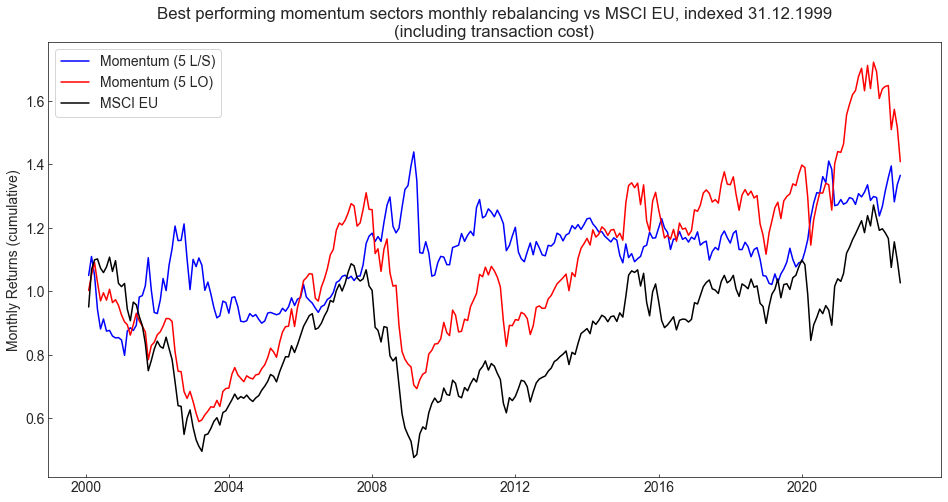

In [72]:
# Plotting the best L/S and LO momentum strategy
# INCL TRANSACTION COST


fig, ax = plt.subplots()
ax.plot(comp_list_2[1].index, comp_list_2[3].mom_indexed, label="Momentum (5 L/S)", color = "blue")
ax.plot(comp_list_lo_2[1].index, comp_list_lo_2[3].mom_indexed, label="Momentum (5 LO)", color = "red")
ax.plot(comp_list_lo_2[1].index,comp_list_lo_2[1].bench_indexed, label="MSCI EU", color="black")
ax.legend(loc="best")
ax.set_ylabel('Monthly Returns (cumulative)')
ax.set_title("Best performing momentum sectors monthly rebalancing vs MSCI EU, indexed 31.12.1999\n(including transaction cost)")

plt.savefig('Momentum_Overview_best_incl_TC.png')
